In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
from parse_midi import Midi
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm, figure
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
set_matplotlib_formats('svg')
plt.rcParams['figure.dpi'] = 1200

import seaborn as sns
sns.set_style("darkgrid")


def filter_timerange(timed_notes, start, end):
    # returns all notes that occurr during start-end
    return timed_notes[(timed_notes.end > start) & (timed_notes.start < end)]


def get_onset_deltas(timed_notes):
    unique_onsets = pd.Series(timed_notes['start'].unique()).sort_values()
    onset_deltas = (unique_onsets - unique_onsets.shift())[1:]
    return onset_deltas[onset_deltas > 0.001]





In [2]:
    
midi_dir = './midi_files'
file_paths = [join(midi_dir, x) for x in listdir(midi_dir)]


In [3]:
midi_objects = []
all_data = []

print('Reading %s midi files...' % len(file_paths))

for fp in file_paths:
    print(fp)
    mid = Midi.from_file(fp)
    midi_objects.append(mid)
    all_data += mid.note_times()


all_data = pd.DataFrame(all_data)
all_data

Reading 21 midi files...
./midi_files/mz_545_3.mid
./midi_files/mz_333_2.mid
./midi_files/mz_332_1.mid
./midi_files/mz_545_1.mid
./midi_files/mz_311_1.mid
./midi_files/mz_545_2.mid
./midi_files/mz_570_1.mid
./midi_files/mz_570_2.mid
./midi_files/mz_330_3.mid
./midi_files/mz_570_3.mid
./midi_files/mz_332_2.mid
./midi_files/mz_330_2.mid
./midi_files/mz_331_1.mid
./midi_files/mz_311_3.mid
./midi_files/mz_333_1.mid
./midi_files/mz_330_1.mid
./midi_files/mz_333_3.mid
./midi_files/mz_331_3.mid
./midi_files/mz_332_3.mid
./midi_files/mz_311_2.mid
./midi_files/mz_331_2.mid


,start,end,midi,vel
0,0.4608,0.5184,79,50
1,0.4608,0.5184,76,42
2,0.6912,0.7488,79,43
3,0.6912,0.7488,76,36
4,0.9216,0.9792,57,30
...,...,...,...,...
68178,342.3744,342.8352,71,53
68179,342.8352,343.2960,61,42
68180,342.8352,343.2960,57,35
68181,342.8352,343.2960,69,51


In [4]:
def calc_slice_duration(timed_notes, pgoal=0.05):
    onset_deltas = get_onset_deltas(timed_notes).sort_values().unique()
    onsets = timed_notes['start']
    slice_duration = 0
    p = 0
    while p <= pgoal:
        count = 0
        for t in onset_deltas:
            if slice_duration >= t:
                count += 1
        p = count / len(onset_deltas)
        slice_duration += 0.001
    print('p:', p)
    return slice_duration


word_duration = calc_slice_duration(all_data, 0.05)


p: 0.060577526679221595


In [5]:
import math

def get_timed_notes(midi_obj):
    return pd.DataFrame(midi_obj.note_times())


def slice_notes(timed_notes, slice_duration, k={}):
    notes_duration = max(timed_notes.end) - min(timed_notes.start)
    num_slices = int(notes_duration // slice_duration) + 1
    slices = {}
    tns = timed_notes.set_index(['start', 'end'])
    for i in range(num_slices):
        start = i * slice_duration
        end = (i + 1) * slice_duration
        cond = (tns.index.get_level_values('end') >= start) & (tns.index.get_level_values('start') <= end)
        in_slice = tns[cond]
        slices[i + x] = in_slice
        

    print('concatting...')
    return pd.concat(slices)


sentences = {}
k = {}
x = 0
for i, mid in enumerate(midi_objects):
    print('Reading Midi Object #', i)
    note_data = get_timed_notes(mid)
    w = slice_notes(note_data, calc_slice_duration(note_data, 0.05), k=x)
    x += len(w)
    sentences[i] = w



Reading Midi Object # 0
p: 0.5
concatting...
Reading Midi Object # 1
p: 0.052941176470588235
concatting...
Reading Midi Object # 2
p: 0.052104208416833664
concatting...
Reading Midi Object # 3
p: 0.225
concatting...
Reading Midi Object # 4
p: 0.12053571428571429
concatting...
Reading Midi Object # 5
p: 0.06382978723404255
concatting...
Reading Midi Object # 6
p: 0.09125475285171103
concatting...
Reading Midi Object # 7
p: 0.16
concatting...
Reading Midi Object # 8
p: 0.08598130841121496
concatting...
Reading Midi Object # 9
p: 0.09868421052631579
concatting...
Reading Midi Object # 10
p: 0.060109289617486336
concatting...
Reading Midi Object # 11
p: 0.06547619047619048
concatting...
Reading Midi Object # 12
p: 0.08753709198813056
concatting...
Reading Midi Object # 13
p: 0.05621301775147929
concatting...
Reading Midi Object # 14
p: 0.08872458410351201
concatting...
Reading Midi Object # 15
p: 0.06296851574212893
concatting...
Reading Midi Object # 16
p: 0.05398457583547558
concatting..

In [6]:
sents = pd.concat(sentences)
sents.head()

midi  vel
    start  end              
0 3 0.4608 0.5184    79   50
           0.5184    76   42
  4 0.4608 0.5184    79   50
           0.5184    76   42
  5 0.6912 0.7488    79   43

In [7]:

all_words = sents.droplevel(0)
all_words.head()


midi  vel
  start  end              
3 0.4608 0.5184    79   50
         0.5184    76   42
4 0.4608 0.5184    79   50
         0.5184    76   42
5 0.6912 0.7488    79   43

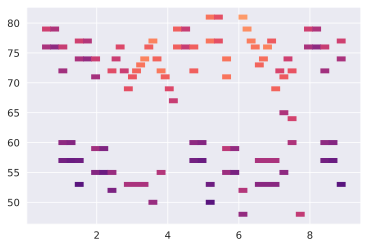

In [8]:


def plot_piano(timed_notes, axis, color=None):
    velocity_map = cm.magma(np.linspace(0,1,90))
    min_width = 0.25

    for _, note in timed_notes.iterrows():
        width = max(min_width, note['end'] - note['start'])
        tr = (note['start'], note['start'] + width)
        midi_note = note['midi']
        vel = int(note['vel'])
        c = color if color is not None else velocity_map[vel]
        axis.plot(tr, [midi_note, midi_note], lw=5, solid_capstyle='butt', color=c)

        
plot_piano(all_data[:100], plt.subplot())

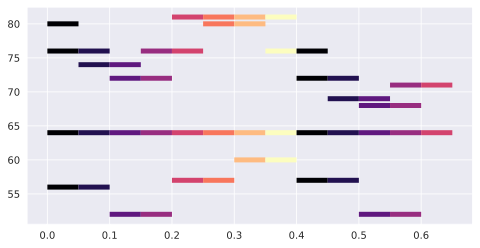

In [9]:
def plot_slices(slices, axis, color=None):
    velocity_map = cm.magma(np.linspace(0,1,8))
    slice_duration = 0.05
    i = 0
    for sid in slices.index.get_level_values(0).unique():
        slc = slices.loc[sid]
#         word = sents[sents['slice_id'] == sid]
        c = color if color is not None else velocity_map[i % 8]
        for midi_note in slc['midi']:
            axis.plot([
                i * slice_duration,
                (i + 1) * slice_duration
            ], [midi_note, midi_note], lw=5, solid_capstyle='butt', color=c)
        i += 1


_, ax = plt.subplots(figsize=(8,4))

plot_slices(sents.loc[0][1000:1050], ax)
# sents.loc[0][0:200].index.get_level_values(0)

In [10]:
simplified_words = all_words.reset_index(level='start', drop=True).reset_index(level='end', drop=True)
print('# simplified words:', max(simplified_words.index))
simplified_words.loc[150]

# simplified words: 448584


,midi,vel
150,48,47
150,80,75
150,57,40
150,81,67


In [26]:
def hash_slice(s):
    try:
        return frozenset(s['midi'])
    except TypeError as e:
        return frozenset([s['midi']])


id_to_word = {}
word_to_id = {}

j = 0
immut_words = []
for i, sid in enumerate(simplified_words.index.drop_duplicates()):
    w = simplified_words.loc[sid]
    immut_slice = hash_slice(w)
    immut_words.append(immut_slice)
    if immut_slice not in word_to_id:
        id_to_word[j] = list([int(x) for x in immut_slice])
        word_to_id[immut_slice] = j
        j += 1

print('# unique words:', len(id_to_word))

# unique words: 10898


In [18]:
compressed = []

for sid in simplified_words.index:
    w = simplified_words.loc[sid]
    immut_slice = hash_slice(w)
    wid = word_to_id[immut_slice]
    compressed.append(wid)


In [19]:
compressed[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
len(compressed)

458364

In [21]:
# save the compressed words
open('words.txt', 'w').write(','.join([str(x) for x in compressed]))

2207311

In [32]:
# Save the id_to_word dictionary
open('id_to_word.json', 'w').write(json.dumps(id_to_word))

/bin/sh: 1: Syntax error: word unexpected (expecting ")")
